# **Section 1: Setups and Imports** <a id="1"></a>

In [1]:
# 🚀 Always run this cell first! It contains all necessary imports.
import gc
import sys
import pprint
import os

import requests
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

import gym # openai gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.jit

import random

import csv
from tabulate import tabulate

from sklearn.utils import resample


# **Section 2: Functions** <a id="2"></a> #

## **2.1. Data Load & Processing Functions** <a id="2.1"></a> ##

In [2]:
def fetch_nhl_play_by_play_data(url):
    """
    Fetch NHL play-by-play data from a given URL and return it as a DataFrame.

    Parameters:
    url (str): The URL from which to fetch the play-by-play data.

    Returns:
    pd.DataFrame: DataFrame containing the extracted play-by-play data.
    """
    # Fetch data from API
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()

        # Extract relevant events
        events = data.get("plays", [])
        away_Team = data.get("awayTeam", [])
        home_Team = data.get("homeTeam", [])
        extracted_data = []

        for event in events:
            event_details = event.get("details", {})
            event_data = {
                "eventId": event.get("eventId"),
                "period": event.get("periodDescriptor", {}).get("number"),
                "time": event.get("timeInPeriod"),
                "away_team": away_Team.get("abbrev"),
                "home_team": home_Team.get("abbrev"),
                "home_team_side": event.get("homeTeamDefendingSide"),
                "eventType": event.get("typeDescKey"),
            }
            # Add event details to event_data
            if event_details:
                for key, value in event_details.items():
                    event_data[key] = value

            extracted_data.append(event_data)

        # Convert to DataFrame
        df = pd.DataFrame(extracted_data)
        return df
    else:
        print("Failed to retrieve data from NHL API. Status code:", response.status_code)
        return None


In [3]:
def print_event_type_counts(df):
    """
    Print the unique event types and their counts in a tabular format.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing play-by-play data.

    Returns:
    None
    """
    event_counts = df['eventType'].value_counts()
    print("List of eventType and their counts:")
    print(tabulate(event_counts.reset_index(), headers=["eventType", "Count"], tablefmt="grid"))

In [4]:
def filter_play_actions(df, play_actions):
    """
    Filter the dataset to keep only relevant play-driving events.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing play-by-play data.
    play_actions (list): List of relevant play-driving events to filter.

    Returns:
    pd.DataFrame: Filtered DataFrame containing only relevant play-driving events.
    """
    # Filter dataset to keep only relevant play-driving events
    df_filtered = df[df["eventType"].str.lower().isin(play_actions)]

    # Count of eventType categories
    event_counts = df_filtered['eventType'].value_counts()

    # Print list of eventType and their counts in tabular format
    print("List of eventType after filtering:")
    print(tabulate(event_counts.reset_index(), headers=["eventType", "Count"], tablefmt="grid"))

    return df_filtered

In [5]:
def replace_event_types(df, existing_event_types, new_event_type):
    """
    Replace one or more event types with a new event type.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    existing_event_types (list or str): One or more existing event types to be replaced.
    new_event_type (str): The new event type.

    Returns:
    pd.DataFrame: The updated DataFrame with replaced event types.
    """
    if isinstance(existing_event_types, str):
        existing_event_types = [existing_event_types]
    
    for event in existing_event_types:
        if event in df['eventType'].values:
            print(f"Replacing event type '{event}' with '{new_event_type}'")
            df['eventType'] = df['eventType'].replace(event, new_event_type)
        else:
            print(f"Event type '{event}' not found in DataFrame")
    
    print("Event type replacement complete")
    return df

In [6]:
def print_column_statistics(df):
    """
    Print a tabular table with list of columns, their number of rows, number of unique values, and their number of null values.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    None
    """
    column_stats = {
        "Column": [],
        "Rows": [],
        "Unique Values": [],
        "Null Values": []
    }

    for col in df.columns:
        column_stats["Column"].append(col)
        column_stats["Rows"].append(df[col].shape[0])
        column_stats["Unique Values"].append(df[col].nunique())
        column_stats["Null Values"].append(df[col].isnull().sum())

    print(tabulate(pd.DataFrame(column_stats), headers="keys", tablefmt="grid"))

In [7]:
def update_team_names(df, csv_file_path="../data/team_id_map.csv"):
    """
    Update the eventOwnerTeamID to a more readable team name using the NHL API or a CSV file.

    Parameters:
    df (pd.DataFrame): DataFrame containing the play-by-play data with eventOwnerTeamId.
    csv_file_path (str): Path to the CSV file containing the team ID map.

    Returns:
    pd.DataFrame: Updated DataFrame with eventOwnerTeam names.
    """
    if os.path.exists(csv_file_path):
        # Load team_id_map from CSV
        team_id_map = pd.read_csv(csv_file_path, index_col=0).squeeze().to_dict()
        print("Loaded team_id_map from CSV.")
    else:
        # Fetch team_id_map from API
        response = requests.get("https://api.nhle.com/stats/rest/en/team")
        data = response.json()
        team_data = data.get("data", [])
        team_id_map = {team["id"]: team["triCode"] for team in team_data}

        # Save team_id_map to CSV
        pd.Series(team_id_map).to_csv(csv_file_path)
        print("Fetched team_id_map from API and saved to CSV.")

    print(team_id_map)

    print("Updating dataset with team names...")
    df["eventOwnerTeam"] = df["eventOwnerTeamId"].map(team_id_map)
    df = df.drop(columns=["eventOwnerTeamId"])

    missing_teams = df[df["eventOwnerTeam"].isnull()]
    if not missing_teams.empty:
        print("Missing team IDs for the following events:")
        print(missing_teams)
    else:
        print("All team IDs are accounted for.")
    
    team_distribution = df["eventOwnerTeam"].value_counts()
    print("Team distribution in the dataset:")
    print(team_distribution)
    
    return df

In [8]:
def add_synthetic_events(df):
    """
    Add synthetic actions like pass, carry-in, or dump-in between events to ensure AI learns logical movement patterns.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing play-by-play data.

    Returns:
    pd.DataFrame: Updated DataFrame with original and synthetic data combined.
    """
    synthetic_actions = []
    print("Starting to add synthetic events...")

    # Iterate through each event in the filtered DataFrame
    for i in range(len(df) - 1):
        current_event = df.iloc[i]
        next_event = df.iloc[i + 1]

        # Check if the same team has possession in consecutive events
        if current_event["eventOwnerTeam"] == next_event["eventOwnerTeam"]:
            x_diff = abs(next_event["xCoord"] - current_event["xCoord"])

            if x_diff > 20:
                action = "carry-in"
                x_coord = current_event["xCoord"] + 10  # Example increment
            else:
                action = "pass"
                x_coord = current_event["xCoord"] + 2  # Example increment

            # Add small random variability to Y-coordinate
            y_coord = current_event["yCoord"] + np.random.randint(-3, 3)

            # Calculate time halfway between current_event and next_event
            current_time = int(current_event["time"].split(":")[0]) * 60 + int(current_event["time"].split(":")[1])
            next_time = int(next_event["time"].split(":")[0]) * 60 + int(next_event["time"].split(":")[1])
            halfway_time = (current_time + next_time) // 2
            time = f"{halfway_time // 60:02}:{halfway_time % 60:02}"

            synthetic_event = {
                "eventId": None,  # Assign a unique identifier if necessary
                "eventType": action,
                "xCoord": x_coord,
                "yCoord": y_coord,
                "period": current_event["period"],
                "time": time,
                "eventOwnerTeam": current_event["eventOwnerTeam"],
                "away_team": current_event["away_team"],
                "home_team": current_event["home_team"],
                "home_team_side": current_event["home_team_side"],
                "zoneCode": current_event["zoneCode"]
            }

            synthetic_actions.append(synthetic_event)
            print(f"Added synthetic event: {synthetic_event}")

    # Convert the list of synthetic actions to a DataFrame
    synthetic_actions_df = pd.DataFrame(synthetic_actions, columns=df.columns)
    print(f"Total synthetic events added: {len(synthetic_actions_df)}")

    # Combine the original DataFrame with the synthetic actions
    df_combined = pd.concat([df, synthetic_actions_df]).sort_values(by=["period", "time"]).reset_index(drop=True)
    print("Synthetic events added and combined with original data.")

    return df_combined


In [9]:
def filter_columns_and_print_stats(df, columns_to_keep):
    """
    Filter the dataframe to keep only relevant columns and print column statistics.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns_to_keep (list): List of columns to keep in the DataFrame.

    Returns:
    pd.DataFrame: The updated DataFrame with only relevant columns.
    """
    # Select only relevant columns
    df_filtered = df[columns_to_keep]

    # Print column statistics
    print_column_statistics(df_filtered)

    return df_filtered

In [10]:
def get_team_name(team_to_train, df):
    """
    Get the team name based on the team to train.

    Parameters:
    team_to_train (str): The team to train, either 'home' or 'away'.
    df (pd.DataFrame): The DataFrame containing the play-by-play data.

    Returns:
    str: The name of the team to train.
    """
    home_team = df["home_team"].iloc[0]
    away_team = df["away_team"].iloc[0]
    return home_team if team_to_train == "home" else away_team


## **2.2. DQN Model Functions** <a id="2.2"></a>

In [11]:
# Define Deep Q-Network (DQN) model for RL of Hockey Play-by-Play
# Why? → This neural network predicts Q-values for all actions based on the current hockey play.
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [12]:
def initialize_networks(input_dim=5, output_dim=6):
    """
    Initialize the online and target networks for the DQN model.

    Parameters:
    input_dim (int): The number of input features for the network.
    output_dim (int): The number of output actions for the network.

    Returns:
    tuple: The initialized online and target networks.
    """
    # Set device (GPU if available)
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # Initialize online and target networks
    online_network = DQN(input_dim=input_dim, output_dim=output_dim).to(device)
    target_network = DQN(input_dim=input_dim, output_dim=output_dim).to(device)
    
    # Copy weights from online network to target network and freeze target network
    target_network.load_state_dict(online_network.state_dict())
    target_network.eval()
    
    return online_network, target_network

In [13]:
# Define Experience Replay Memory
# Why? → Stores past experiences so the AI can learn from past plays instead of just the most recent ones.
# Will be used to train the model - stores Q-values and rewards for each action taken.
# Experience = (state, action, reward, next_state, done)
# Memory = list of experiences
def store_experience(state, action, reward, next_state, done):
    """
    Store an experience in the replay memory.

    Parameters:
    state (array): The current state.
    action (int): The action taken.
    reward (float): The reward received.
    next_state (array): The next state.
    done (bool): Whether the episode is done.

    Returns:
    None
    """
    memory.append((state, action, reward, next_state, done))
    #print(f"Stored experience: State={state}, Action={action}, Reward={reward}, Next State={next_state}, Done={done}")
    
    if len(memory) > max_memory_size:
        removed_experience = memory.pop(0)
        #print(f"Memory full. Removed oldest experience: {removed_experience}")

    #print(f"Current memory size: {len(memory)}")


In [14]:
# Define Epsilon-Greedy Strategy
def select_action(state):
    """
    Select an action using the epsilon-greedy strategy.

    Parameters:
    state (array): The current state.

    Returns:
    int: The selected action.
    """
    if np.random.rand() < epsilon:  # Explore (random action)
        action = np.random.randint(0, 6)  # Updated to match output_dim (6 actions)
        #print(f"Exploring: Selected random action {action}")
    else:  # Exploit (use learned Q-values)
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        state_tensor = state_tensor.unsqueeze(0)  # Adds batch dimension
        with torch.no_grad():
            action = torch.argmax(online_network(state_tensor)).item()
        #print(f"Exploiting: Selected best action {action} based on Q-values")
    
    return action


In [15]:
def train_network():
    """
    Train the online network using experiences from the replay memory.
    """
    if len(memory) < batch_size:
        return  # Don't train until enough experiences are collected

    batch = random.sample(memory, batch_size)  # Sample batch from memory

    # Convert to tensors efficiently
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)  # Ensure long type for indexing
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Normalize states
    states = (states - states.mean(dim=0)) / (states.std(dim=0) + 1e-5)
    next_states = (next_states - next_states.mean(dim=0)) / (next_states.std(dim=0) + 1e-5)

    # Compute Q-values and targets
    q_values = online_network(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Get Q-value for chosen action

    with torch.no_grad():
        next_q_values = target_network(next_states)
        target_q_value = rewards + gamma * next_q_values.max(1)[0] * (1 - dones)

    # Normalize per-state Q-values (fix: normalize across batch, not dim=1)
    q_value = (q_value - q_value.mean(dim=0)) / (q_value.std(dim=0) + 1e-5)
    target_q_value = (target_q_value - target_q_value.mean(dim=0)) / (target_q_value.std(dim=0) + 1e-5)
    
    # Compute loss & update weights
    loss = loss_fn(q_value, target_q_value)  # Minimize the difference between predicted and target Q-values
    optimizer.zero_grad()
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights to minimize loss

In [16]:
# Updated Hockey Play-by-Play RL Environment with Training Logic
# Why? → This version includes training logic to update the online network based on past experiences.
# Calculates reward based on actual event in dataset and chosen action by the agent. How? → Assigns rewards based on event type.

class HockeyPlayRL(gym.Env):
    """
    Custom Environment for Hockey Play-by-Play Reinforcement Learning.
    
    Attributes:
        df (pd.DataFrame): DataFrame containing play-by-play data.
        team (str): Name of the team to train.
        model (torch.nn.Module): Trained model for predicting actions.
        action_space (gym.spaces.Discrete): Discrete action space with 7 possible actions.
        observation_space (gym.spaces.Box): Continuous observation space.
        current_step (int): Current step in the environment.
        prev_action (str): Previous action taken by the agent.
    """
    
    def __init__(self, df, team_to_train_name, model=None):
        """
        Initialize the HockeyPlayRL environment.
        
        Args:
            df (pd.DataFrame): DataFrame containing play-by-play data.
            team_to_train_name (str): Name of the team to train.
            model (torch.nn.Module, optional): Trained model for predicting actions. Defaults to None.
        """
        super(HockeyPlayRL, self).__init__()
        self.df = df.reset_index(drop=True)
        self.action_space = spaces.Discrete(6)  # 6 actions now
        self.observation_space = spaces.Box(
            low=np.array([1, 0, -100, -50, -10]),
            high=np.array([3, 1200, 100, 50, 10]),
            dtype=np.float32
        )
        self.current_step = 0
        self.team = team_to_train_name
        self.model = model
        self.prev_action = None

    def reset(self):
        """
        Reset the environment to the initial state.
        
        Returns:
            np.array: Initial observation of the environment.
        """
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        """
        Get the current game state as an RL observation, adjusting for team perspective.
        
        Returns:
            np.array: Current observation of the environment.
        """
        row = self.df.iloc[self.current_step]
        period = row["period"]
        time = int(row["time"].split(":")[0]) * 60 + int(row["time"].split(":")[1])
        x_coord = row["xCoord"] if not np.isnan(row["xCoord"]) else 0
        if period % 2 == 0:  # Flip X for even periods
            x_coord = -x_coord
        y_coord = row["yCoord"] if not np.isnan(row["yCoord"]) else 0
        score_diff = (row["awayScore"] - row["homeScore"]) if not np.isnan(row["awayScore"]) else 0
       
        # Normalize and return the state parameters
        return self.normalize_state(period, time, x_coord, y_coord, score_diff)

    def step(self, action):
        """
        Apply an action and transition to the next state, ensuring AI only makes decisions on its team's actions.
        
        Args:
            action (int): Action chosen by the agent.
        
        Returns:
            tuple: Next observation, reward, done flag, and additional info.
        """
        row = self.df.iloc[self.current_step]
        action_name = self.action_name(action)
        event_type = row["eventType"].strip().lower()  # Normalize eventType
        reward = 10  # Baseline reward for taking any action

        # Define defensive and offensive actions
        defensive_actions = ["hit", "blocked-shot", "takeaway"]
        offensive_actions = ["shot", "pass", "carry-in"]

        # Assign full rewards for exact matches
        if action_name == event_type:
            reward += 50  # Exact match gives extra points    
        # Assign partial rewards for category matches
        elif action_name in defensive_actions and event_type in defensive_actions:
            reward += 20  # Defensive play in defensive situation
        elif action_name in offensive_actions and event_type in offensive_actions:
            reward += 20  # Offensive play in offensive situation
        elif action_name == "hit":
            reward += 10  # Reduce hit value
        elif action_name == "blocked-shot":
            reward += 20  # Reduce hit value
        elif action_name == "shot":
            reward += 40  # Encourage AI to take shots
        elif action_name == "takeaway":
            reward += 20  # Boost takeaways so AI plays defense
        elif action_name == "pass":
            reward += 40  # Encourage team play
        elif action_name == "carry-in":
            reward = 30  # Encourage team play

        # Encourage variety in actions
        if action_name == self.prev_action:  
            reward -= 20  # Small penalty for repeating the same move every time
        
        # Normalize the reward before returning to help with training stability
        reward = self.normalize_reward(reward)  

        # Update current step to progress through the dataset
        self.current_step += 1  

        done = self.current_step >= len(self.df) - 1
        self.prev_action = action_name
        return self._next_observation(), reward, done, {}

    def predict_best_action(self, state):
        """
        Predict the best action using the trained model.
        
        Args:
            state (np.array): Current state of the environment.
        
        Returns:
            int: Predicted best action.
        """
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = self.model(state_tensor)
            action = torch.argmax(q_values).item()
        return action

    def action_name(self, action):
        """
        Convert action index to action name.
        
        Args:
            action (int): Action index.
        
        Returns:
            str: Action name.
        """
        action_mapping = {
            0: "shot",
            1: "takeaway",
            2: "hit",
            3: "blocked-shot",
            4: "pass",
            5: "carry-in"
        }
        return action_mapping[action]
    
    def normalize_reward(self, reward, recent_rewards=[]):
        """
        Normalize rewards dynamically using a moving window.
        This prevents reward explosion and ensures balance.
        """
        recent_rewards.append(reward)

        # Keep the last 100 rewards for normalization
        if len(recent_rewards) > 100:
            recent_rewards.pop(0)

        mean_reward = np.mean(recent_rewards) if recent_rewards else 0
        std_reward = np.std(recent_rewards) if recent_rewards else 1
        return (reward - mean_reward) / (std_reward + 1e-5)
    
    def normalize_state(self, period, time, x_coord, y_coord, score_diff):
        """
        Normalize state features for consistency across training and inference.
        
        Args:
            period (int): The period of the game.
            time (int): The time in seconds.
            x_coord (float): The x-coordinate on the rink.
            y_coord (float): The y-coordinate on the rink.
            score_diff (int): The score difference.
        
        Returns:
            np.array: Normalized state features.
        """
        period = (period - 1) / 3  # Normalize period (1 to 3 → 0 to 1)
        time = time / 1200  # Normalize time (0 to 1200 → 0 to 1)
        x_coord = (x_coord + 100) / 200  # Normalize X-coord (-100 to 100 → 0 to 1)
        y_coord = (y_coord + 50) / 100  # Normalize Y-coord (-50 to 50 → 0 to 1)
        score_diff = (score_diff + 5) / 10  # Normalize score difference (-5 to 5 → 0 to 1)
        
        return np.array([period, time, x_coord, y_coord, score_diff], dtype=np.float32)

In [17]:
def update_target_network():
    """
    Update the target network with the weights from the online network.

    This function copies the weights from the online network to the target network
    to ensure that the target network remains a stable reference for learning.

    Parameters:
    None

    Returns:
    None
    """
    target_network.load_state_dict(online_network.state_dict())  # Copy weights

In [18]:
def update_epsilon():
    """
    Update the epsilon value to reduce randomness over time as the AI learns to exploit the best moves.

    This function updates the global epsilon value by multiplying it with the epsilon_decay factor,
    ensuring that it does not go below the epsilon_min value.

    Parameters:
    None

    Returns:
    None
    """
    global epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Reduce randomness over time


In [19]:
def train_dqn(hockey_env_rl, num_episodes, skip_training, online_network_path, target_network_path):
    """
    Train the Deep Q-Network (DQN) for Hockey Play-by-Play.

    Parameters:
    hockey_env_rl (HockeyPlayRL): The HockeyPlayRL environment instance.
    num_episodes (int): Number of episodes (games) to play.
    skip_training (bool): Whether to skip training if already trained.
    online_network_path (str): Path to save/load the online network model.
    target_network_path (str): Path to save/load the target network model.

    Returns:
    None
    """
    if skip_training:
        print("Training skipped. Loading pre-trained model...")
        # Load existing models
        with open(online_network_path, "rb") as model_file:
            online_network = pickle.load(model_file)
        with open(target_network_path, "rb") as model_file:
            target_network = pickle.load(model_file)
        print("Model loaded.")
    else:
        print("Training started...")
        for episode in range(num_episodes):
            state = hockey_env_rl.reset()  # Reset game (start new episode with Hockey RL Environment)
            done = False
            step_count = 0

            while not done:  # Goes through each row in the dataset (definition of done)
                action = select_action(state)  # Step 3: Choose action (start with random actions, then exploit learned Q-values - i.e. choose best action)
                next_state, reward, done, _ = hockey_env_rl.step(action)  # Step 4: For the chosen action, get the next state (i.e. observations/features), reward of chosen action (either hard-coded rewards if choose same as eventType in dataset or 0 if not), and if the game is done
                store_experience(state, action, reward, next_state, done)  # Step 5: Store experience (state/observations, chosen action, reward, next state/observation, if done)
                
                step_count += 1  # Increment step counter
                if step_count % 4 == 0:  # Train only every 4 steps
                    train_network()  # Step 6: Train neural network -- update weights to minimize loss between predicted q-value (current model output for chosen action) and target q-value (immediate reward of chosen action if the same as dataset + future reward of next state/sitauation in dataset) (i.e. improve Q-value predictions to be closer to Q-value for that state-action pair)
                
                state = next_state  # Move to next state (situational observations in dataset); continue until done all rows in dataset

            update_target_network()  # Step 6: Update target network every episode (going through all rows in dataset)
            update_epsilon()  # Step 7: Reduce exploration (ε) over time to go from random actions to exploiting learned Q-values

            # Print progress every 10 episodes
            if episode % 10 == 0:
                print(f"Episode {episode}/{num_episodes} completed. Epsilon: {epsilon:.2f}")

        print("Training complete!")


In [20]:
def simulate_hockey_game(log_file, num_simulated_states, hockey_env_rl, online_network):
    """
    Simulate a variety of hockey game states, call predict_best_action(state), and log the AI’s decisions to a CSV file.

    Parameters:
    log_file (str): Path to the log file.
    num_simulated_states (int): Number of simulated entries.
    hockey_env_rl (HockeyPlayRL): The HockeyPlayRL environment instance.
    online_network (DQN): The trained online network model.

    Returns:
    pd.DataFrame: DataFrame containing the logged simulated states.
    """
    log_data = []

    # Set online network for prediction
    hockey_env_rl.model = online_network

    # Generate random hockey states and predict actions
    for _ in range(num_simulated_states):
        period = np.random.randint(1, 4)  # Period 1-3
        time = np.random.randint(0, 1200)  # Time in seconds (up to 20 min)
        x_coord = np.random.randint(-100, 100)  # Rink width range
        y_coord = np.random.randint(-50, 50)  # Rink height range
        score_diff = np.random.randint(-5, 5)  # Score difference range (-5 to +5)

        # Create state array
        state = [period, time, x_coord, y_coord, score_diff]
        state_normalized = hockey_env_rl.normalize_state(*state)

        # Move normalized state to the same device as the model
        state_tensor = torch.tensor(state_normalized, dtype=torch.float32).to(device)

        # Predict AI's best action
        action = hockey_env_rl.predict_best_action(state_tensor)
        action_name = hockey_env_rl.action_name(action)

        # Log result
        log_data.append(state + [action, action_name])

    # Convert log data to DataFrame
    df_log = pd.DataFrame(log_data, columns=["Period", "Time", "X Coord", "Y Coord", "Score Diff", "Action", "Action Name"])

    # Save DataFrame to CSV
    df_log.to_csv(log_file, index=False)

    print("Simulation complete! Logged simulated states to hockey_action_log.csv")
    return df_log

In [21]:
def plot_action_heatmaps(log_df):
    """
    Generate KDE (density) heatmaps for AI decision-making locations.

    Parameters:
        log_df (pd.DataFrame): DataFrame with columns ["X Coord", "Y Coord", "Action Name"]
    """
    unique_actions = log_df["Action Name"].unique()
    
    plt.figure(figsize=(15, 10))
    
    for i, action in enumerate(unique_actions, 1):
        plt.subplot(2, 3, i)
        subset = log_df[log_df["Action Name"] == action]
        
        sns.kdeplot(x=subset["X Coord"], y=subset["Y Coord"], cmap="coolwarm", fill=True, levels=100)
        plt.title(f"Heatmap of {action}")
        plt.xlabel("X Coord")
        plt.ylabel("Y Coord")

        # Add offensive/neutral/defensive zone lines
        min_x, max_x = log_df["X Coord"].min(), log_df["X Coord"].max()
        range_x = max_x - min_x
        plt.axvline(x=min_x + range_x * 0.33, color="blue", linestyle="--")
        plt.axvline(x=min_x + range_x * 0.66, color="blue", linestyle="--")
        plt.axvline(x=min_x + range_x * 0.5, color="red", linestyle="-")

    plt.tight_layout()
    
    # Save plot as image
    datetime = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"../outputs/heatmap_actions_zones_{datetime}.png", bbox_inches='tight')
    
    plt.show()

    

In [22]:
def compute_reward_by_game(num_episodes, episode_length, hockey_env_rl, reward_log_file):
    """
    Compute the reward by game (or episode) and save the reward log to a CSV file.

    Parameters:
    num_episodes (int): Number of episodes (games) to simulate.
    episode_length (int): Maximum steps per episode.
    hockey_env_rl (HockeyPlayRL): The HockeyPlayRL environment instance.
    reward_log_file (str): Path to save the reward log CSV file.

    Returns:
    pd.DataFrame: DataFrame containing the reward log.
    """
    reward_log = []  # Store total reward per episode

    for episode in range(num_episodes):
        # Reset environment for new episode and return first state
        state = hockey_env_rl.reset()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

        done = False  # Episode completion flag
        total_reward = 0  # Track cumulative reward for this episode

        for step in range(episode_length):  # Limit episode length
            action = hockey_env_rl.predict_best_action(state_tensor)  # Predict best action
            next_state, reward, done, _ = hockey_env_rl.step(action)

            total_reward += reward  # Accumulate rewards

            # Update `state` to `next_state` for next iteration
            state = next_state
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)  # Move to device

            if done:
                break  # Stop episode if max steps reached

        reward_log.append(total_reward)  # Store total reward for episode
        print(f"Episode {episode} completed. Total Reward: {total_reward}")

    # Save reward log as CSV
    reward_df = pd.DataFrame(reward_log, columns=["Reward"])
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    reward_df.to_csv(f"{reward_log_file}_{timestamp}.csv", index=False)

    print("Simulation complete! Logged rewards per episode.")
    return reward_df

In [23]:
def plot_reward_progression(reward_log):
    """
    Plot reward progression over training episodes.
    
    Parameters:
        reward_log (pd.DataFrame): DataFrame containing cumulative rewards per episode.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(reward_log['Reward'], label="Total Reward per Episode", color="blue")
    plt.axhline(y=reward_log['Reward'].mean(), color="red", linestyle="--", label="Average Reward")
    
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("AI Learning Progress: Reward Progression")
    plt.legend()
    plt.show()


In [24]:
def test_action_distribution(env, num_samples=100):
    """
    Test AI's action distribution using `predict_best_action` and print Q-values.
    
    Parameters:
        env: HockeyPlayRL environment with trained model
        num_samples (int): Number of times to simulate an action choice
    
    Returns:
        pd.DataFrame: Action distribution for analysis
    """
    action_counts = {env.action_name(i): 0 for i in range(env.action_space.n)}

    for _ in range(num_samples):
        # **Generate a Random State**
        period = np.random.randint(1, 4)  # Period 1-3
        time = np.random.randint(0, 1200)  # Time in seconds (up to 20 min)
        x_coord = np.random.randint(-100, 100)  # Rink width range
        y_coord = np.random.randint(-50, 50)  # Rink height range
        score_diff = np.random.randint(-5, 5)  # Score difference range (-5 to +5)

        # **Normalize the state features (same as step function)**
        state = np.array([period, time, x_coord, y_coord, score_diff], dtype=np.float32)
        state = env.normalize_state(period, time, x_coord, y_coord, score_diff)
        state = torch.tensor(state, dtype=torch.float32).to(device)

        # **Use predict_best_action() for consistency**
        action = env.predict_best_action(state)
        action_name = env.action_name(action)
        
        action_counts[action_name] += 1
        
    return pd.DataFrame(list(action_counts.items()), columns=["Action", "Count"])


In [25]:
def compare_ai_vs_nhl(ai_log, nhl_df):
    """
    Compare AI's action decisions with real NHL data.
    
    Parameters:
        ai_log (pd.DataFrame): DataFrame of AI action counts.
        nhl_df (pd.DataFrame): DataFrame of real NHL play-by-play actions.
    """
    ai_action_counts = ai_log.set_index("Action")["Count"]
    nhl_action_counts = nhl_df["eventType"].value_counts()

    comparison_df = pd.DataFrame({
        "AI Actions": ai_action_counts,
        "NHL Actions": nhl_action_counts
    }).fillna(0)

    comparison_df.plot(kind="bar", title="AI vs NHL Action Distribution")
    plt.show()

In [26]:
def downsample_events(df):
    """
    Downsample overrepresented events in the dataframe to balance the event type distribution.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing play-by-play data.

    Returns:
    pd.DataFrame: The updated DataFrame with balanced event type distribution.
    """
    event_counts = df["eventType"].value_counts()
    max_count = int(event_counts.mean())  # Keep event counts near the dataset average

    # Downsample overrepresented events
    balanced_df = pd.concat([
        resample(df[df["eventType"] == event], 
                 replace=False, 
                 n_samples=min(max_count, len(df[df["eventType"] == event])), 
                 random_state=42)
        for event in event_counts.index
    ])

    # Shuffle dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Balanced DataFrame shape: {balanced_df.shape}")
    print(f"Final event type distribution:\n{balanced_df['eventType'].value_counts()}")

    return balanced_df

## **2.3. DDQN Functions** <a id="2.3"></a> #

In [27]:
def train_network_ddqn():
    """
    Train the online network using experiences from the replay memory.
    Updated for Double DQN where we use the online network to select actions and the target network to evaluate them.
    """
    if len(memory) < batch_size:
        return  # Don't train until enough experiences are collected

    batch = random.sample(memory, batch_size)  # Sample batch from memory

    # Convert to tensors efficiently
    states, actions, rewards, next_states, dones = zip(*batch)
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)  # Ensure long type for indexing
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Normalize states
    states = (states - states.mean(dim=0)) / (states.std(dim=0) + 1e-5)
    next_states = (next_states - next_states.mean(dim=0)) / (next_states.std(dim=0) + 1e-5)

    # Compute Q-values and targets
    q_values = online_network(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Get Q-value for chosen action

    # **Double DQN Update**
    with torch.no_grad():
        next_actions = torch.argmax(online_network(next_states), dim=1)  # Use Online Network for action selection
        next_q_values = target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)  # Target Network for value
        target_q_value = rewards + gamma * next_q_values * (1 - dones)

    # Normalize per-state Q-values (fix: normalize across batch, not dim=1)
    q_value = (q_value - q_value.mean(dim=0)) / (q_value.std(dim=0) + 1e-5)
    target_q_value = (target_q_value - target_q_value.mean(dim=0)) / (target_q_value.std(dim=0) + 1e-5)
    
    # Compute loss & update weights
    loss = loss_fn(q_value, target_q_value)  # Minimize the difference between predicted and target Q-values
    optimizer.zero_grad()
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights to minimize loss

In [28]:
def train_ddqn(hockey_env_rl, num_episodes, skip_training, online_network_path, target_network_path):
    """
    Train the Double Deep Q-Network (DQN) for Hockey Play-by-Play.

    Parameters:
    hockey_env_rl (HockeyPlayRL): The HockeyPlayRL environment instance.
    num_episodes (int): Number of episodes (games) to play.
    skip_training (bool): Whether to skip training if already trained.
    online_network_path (str): Path to save/load the online network model.
    target_network_path (str): Path to save/load the target network model.

    Returns:
    None
    """
    if skip_training:
        print("Training skipped. Loading pre-trained model...")
        # Load existing models
        with open(online_network_path, "rb") as model_file:
            online_network = pickle.load(model_file)
        with open(target_network_path, "rb") as model_file:
            target_network = pickle.load(model_file)
        print("Model loaded.")
    else:
        print("Training started...")
        for episode in range(num_episodes):
            state = hockey_env_rl.reset()  # Reset game (start new episode with Hockey RL Environment)
            done = False
            step_count = 0

            while not done:  # Goes through each row in the dataset (definition of done)
                action = select_action(state)  # Step 3: Choose action (start with random actions, then exploit learned Q-values - i.e. choose best action)
                next_state, reward, done, _ = hockey_env_rl.step(action)  # Step 4: For the chosen action, get the next state (i.e. observations/features), reward of chosen action (either hard-coded rewards if choose same as eventType in dataset or 0 if not), and if the game is done
                store_experience(state, action, reward, next_state, done)  # Step 5: Store experience (state/observations, chosen action, reward, next state/observation, if done)
                
                step_count += 1  # Increment step counter
                if step_count % 4 == 0:  # Train only every 4 steps
                    train_network_ddqn()  # **Step 6: Train neural network with DDQN
                
                state = next_state  # Move to next state (situational observations in dataset); continue until done all rows in dataset

            update_target_network()  # Step 6: Update target network every episode
            update_epsilon()  # Step 7: Reduce exploration (ε) over time

            # Print progress every 10 episodes
            if episode % 10 == 0:
                print(f"Episode {episode}/{num_episodes} completed. Epsilon: {epsilon:.2f}")

        print("Training complete!")


In [29]:
def reset_globals_for_ddqn():
    """
    Reset global variables for Double Deep Q-Network (DDQN) training.

    This function initializes the online and target networks, sets up the experience replay memory,
    and defines the epsilon-greedy strategy parameters, loss function, optimizer, batch size, and discount factor.

    Globals:
        online_network (torch.nn.Module): The online network for DDQN.
        target_network (torch.nn.Module): The target network for DDQN.
        memory (list): Experience replay memory.
        max_memory_size (int): Maximum size of the experience replay memory.
        epsilon (float): Initial epsilon value for epsilon-greedy strategy.
        epsilon_min (float): Minimum epsilon value for epsilon-greedy strategy.
        epsilon_decay (float): Decay rate for epsilon value.
        loss_fn (torch.nn.Module): Loss function for training.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        batch_size (int): Batch size for training.
        gamma (float): Discount factor for future rewards.

    Returns:
        None
    """
    global online_network, target_network, memory, max_memory_size, epsilon, epsilon_min, epsilon_decay, loss_fn, optimizer, batch_size, gamma
    online_network, target_network = initialize_networks()
    memory = []  # Initialize memory for Experience Replay
    max_memory_size = 10000  # Store last 10,000 experiences (experience = state, action, reward, next_state, done)
    epsilon = 1.0  # Start fully random
    epsilon_min = 0.1  # Minimum randomness
    epsilon_decay = 0.999  # Reduce randomness over time
    loss_fn = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = optim.Adam(online_network.parameters(), lr=0.005)  # Adam Optimizer
    batch_size = 16  # Number of experiences to sample for training
    gamma = 0.95  # Discount factor for future rewards

## **2.4 Dueling DQN Functions** <a id="2.4"></a> ##

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()

        # Shared layers (feature extraction)
        self.feature = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        # State-value stream (V(s))
        self.value_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output single state value
        )

        # Advantage stream (A(s, a))
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)  # Output advantage per action
        )

    def forward(self, x):
        features = self.feature(x)

        value = self.value_stream(features)  # Compute state-value
        advantage = self.advantage_stream(features)  # Compute advantage values

        # Combine value and advantage into final Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values


In [31]:
def reset_globals_for_duelingdqn():
    """
    Reset global variables for Dueling Deep Q-Network (Deuling DQN) training.

    This function initializes the online and target networks, sets up the experience replay memory,
    and defines the epsilon-greedy strategy parameters, loss function, optimizer, batch size, and discount factor.

    Globals:
        online_network_dueling (torch.nn.Module): The online network for Dueling DQN.
        target_network_dueling (torch.nn.Module): The target network for Dueling DQN.
        memory (list): Experience replay memory.
        max_memory_size (int): Maximum size of the experience replay memory.
        epsilon (float): Initial epsilon value for epsilon-greedy strategy.
        epsilon_min (float): Minimum epsilon value for epsilon-greedy strategy.
        epsilon_decay (float): Decay rate for epsilon value.
        loss_fn (torch.nn.Module): Loss function for training.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        batch_size (int): Batch size for training.
        gamma (float): Discount factor for future rewards.

    Returns:
        None
    """
    global online_network, target_network, memory, max_memory_size, epsilon, epsilon_min, epsilon_decay, loss_fn, optimizer, batch_size, gamma
    online_network, target_network = initialize_networks_duelingDQN()
    memory = []  # Initialize memory for Experience Replay
    max_memory_size = 10000  # Store last 10,000 experiences (experience = state, action, reward, next_state, done)
    epsilon = 1.0  # Start fully random
    epsilon_min = 0.1  # Minimum randomness
    epsilon_decay = 0.999  # Reduce randomness over time
    loss_fn = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = optim.Adam(online_network.parameters(), lr=0.005)  # Adam Optimizer
    batch_size = 16  # Number of experiences to sample for training
    gamma = 0.95  # Discount factor for future rewards

In [32]:
def initialize_networks_duelingDQN(input_dim=5, output_dim=6):
    """
    Initialize the online and target networks for the Dueling DQN model.

    Parameters:
    input_dim (int): The number of input features for the network.
    output_dim (int): The number of output actions for the network.

    Returns:
    tuple: The initialized online and target networks.
    """
    # Set device (GPU if available)
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # Initialize online and target networks
    online_network = DuelingDQN(input_dim=input_dim, output_dim=output_dim).to(device)
    target_network = DuelingDQN(input_dim=input_dim, output_dim=output_dim).to(device)
    
    # Copy weights from online network to target network and freeze target network
    target_network.load_state_dict(online_network.state_dict())
    target_network.eval()
    
    return online_network, target_network

## **2.5. Proximal Policy Optimization (PPO) Functions** <a id="2.5"></a> ##

In [ ]:
class ActorCritic(nn.Module):
    """
    Actor-Critic model for Reinforcement Learning.

    This model consists of shared layers for feature extraction, an actor network for policy prediction,
    and a critic network for state-value estimation.

    Attributes:
        feature (nn.Sequential): Shared layers for feature extraction.
        actor (nn.Sequential): Actor network for policy prediction.
        critic (nn.Sequential): Critic network for state-value estimation.
    """

    def __init__(self, input_dim, output_dim):
        """
        Initialize the ActorCritic model.

        Parameters:
            input_dim (int): The number of input features.
            output_dim (int): The number of output actions.
        """
        super(ActorCritic, self).__init__()

        # Shared layers
        self.feature = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        # Actor (Policy)
        self.actor = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Softmax(dim=-1)  # Outputs action probabilities
        )

        # Critic (State-Value Function)
        self.critic = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Outputs a single state-value
        )

    def forward(self, x):
        """
        Forward pass through the ActorCritic model.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            tuple: A tuple containing action probabilities (π(s)) and state value (V(s)).
        """
        features = self.feature(x)
        action_probs = self.actor(features)  # π(s)
        state_value = self.critic(features)  # V(s)
        return action_probs, state_value


In [ ]:
def ppo_loss(old_probs, new_probs, advantages, epsilon=0.2):
    """
    Compute the Proximal Policy Optimization (PPO) loss.

    Parameters:
    old_probs (torch.Tensor): The probabilities of the actions taken under the old policy.
    new_probs (torch.Tensor): The probabilities of the actions taken under the new policy.
    advantages (torch.Tensor): The advantages of the actions taken.
    epsilon (float): The clipping parameter to limit the change in policy. Default is 0.2.

    Returns:
    torch.Tensor: The computed PPO loss.
    """
    ratio = new_probs / (old_probs + 1e-10)  # Avoid division by zero
    clipped_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) # Clip the ratio between (1-epsilon) and (1+epsilon)
    loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean() # Take the minimum of the unclipped and clipped loss
    return loss


In [ ]:
def train_ppo(env, actor_critic, optimizer, num_epochs=5, gamma=0.99, epsilon=0.2):
    """
    Train the Proximal Policy Optimization (PPO) model.

    Parameters:
    env (gym.Env): The environment to train on.
    actor_critic (nn.Module): The Actor-Critic model.
    optimizer (torch.optim.Optimizer): The optimizer for training.
    num_epochs (int): Number of epochs to train. Default is 5.
    gamma (float): Discount factor for future rewards. Default is 0.99.
    epsilon (float): Clipping parameter to limit the change in policy. Default is 0.2.

    Returns:
    nn.Module: The trained Actor-Critic model.
    """
    for epoch in range(num_epochs):
        states, actions, rewards, next_states, dones, old_probs = collect_trajectory(env, actor_critic) # collect sample (500) of experiences (state/action/reward/next-state/if done/old_prob = probability of each action on the state)
        
        advantages, returns = compute_advantages(rewards, next_states, dones, actor_critic, gamma)

        for _ in range(5):  # Train multiple times on collected data
            new_probs, state_values = actor_critic(states) # Call model to get policy (probability of actions) and value for given state

            # Calculate 2 losses: ppo_loss = new_probs/old_probs*action_advantage (negated so maximizing rather then minimizing), (2) state value 
            loss_actor = ppo_loss(old_probs, new_probs.gather(1, actions.unsqueeze(-1)), advantages, epsilon)
            loss_critic = nn.MSELoss()(state_values.squeeze(), returns)

            # Update weights to minimize losses (or maximize ppo_loss)
            optimizer.zero_grad()
            (loss_actor + loss_critic).backward()
            optimizer.step()

    return actor_critic


In [ ]:
def collect_trajectory(env, actor_critic, num_steps=500):
    """
    Runs the agent in the environment for `num_steps` and collects:
    - States
    - Actions
    - Rewards
    - Next states
    - Done flags
    - Action probabilities

    Returns these as tensors for PPO training.
    """
    states, actions, rewards, next_states, dones, action_probs = [], [], [], [], [], []

    state = env.reset()
    for _ in range(num_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            action_prob, _ = actor_critic(state_tensor)
        
        action_dist = torch.distributions.Categorical(action_prob)  # Convert to probability distribution
        action = action_dist.sample()  # Sample action based on probabilities

        next_state, reward, done, _ = env.step(action.item())  # Take action

        # Store experience
        states.append(state)
        actions.append(action.item())
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)
        action_probs.append(action_prob[:, action.item()].item())

        state = next_state  # Update to new state

        if done:  # Restart if episode ends
            state = env.reset()

    # Convert lists to tensors
    return (
        torch.tensor(states, dtype=torch.float32),
        torch.tensor(actions, dtype=torch.long),
        torch.tensor(rewards, dtype=torch.float32),
        torch.tensor(next_states, dtype=torch.float32),
        torch.tensor(dones, dtype=torch.float32),
        torch.tensor(action_probs, dtype=torch.float32),
    )


In [ ]:
def compute_advantages(rewards, next_states, dones, actor_critic, gamma=0.99):
    """
    Compute advantages and discounted returns for PPO training.

    Parameters:
    rewards (list): List of rewards obtained from the environment.
    next_states (torch.Tensor): Tensor of next states.
    dones (list): List of done flags indicating episode termination.
    actor_critic (nn.Module): The Actor-Critic model.
    gamma (float): Discount factor for future rewards. Default is 0.99.

    Returns:
    tuple: A tuple containing:
        - advantages (torch.Tensor): Tensor of computed advantages.
        - returns (torch.Tensor): Tensor of computed discounted returns.
    """
    with torch.no_grad():
        _, next_state_values = actor_critic(next_states)  # Get V(s') value of state from model
    
    # Initialize
    advantages = []
    returns = []
    gae = 0  # Generalized Advantage Estimation (GAE) accumulator

    for i in reversed(range(len(rewards))):
        td_error = rewards[i] + gamma * next_state_values[i] * (1 - dones[i]) - next_state_values[i] # temporary difference error = game actual reward - predicted value/reward in model + discountered future statte value
        gae = td_error + gamma * 0.95 * (1 - dones[i]) * gae  # λ = 0.95 for stable advantage estimation
        advantages.insert(0, gae) # gae = advantage = relative value of each action
        returns.insert(0, gae + next_state_values[i])  # Compute return (V + advantage)

    return torch.tensor(advantages, dtype=torch.float32), torch.tensor(returns, dtype=torch.float32)


## **2.6. Utility Functions** <a id="2.6"></a> ##

# **Section 3: Load Data** <a id="3"></a>

In [33]:
# Define the file path
csv_file_path = "../data/csv/nhl_play_by_play.csv"

# Check if the CSV file already exists
if os.path.exists(csv_file_path):
    # Load data from CSV
    df = pd.read_csv(csv_file_path)
    print("Data loaded from nhl_play_by_play.csv")
else:
    # Example usage
    game_id = "2022030411"
    url = f"https://api-web.nhle.com/v1/gamecenter/{game_id}/play-by-play"
    df = fetch_nhl_play_by_play_data(url)

    # Save to CSV
    if df is not None:
        df.to_csv(csv_file_path, index=False)
        print("Data saved to nhl_play_by_play.csv")
    else:
        print("No data to save. DataFrame is None.")

Data loaded from nhl_play_by_play.csv


# **Section 4: Pre-Process Data** <a id="4"></a>

In [34]:
# Print event types in the hockey play-by-play dataset to decide which ones to use in the model
print_event_type_counts(df)

List of eventType and their counts:
+----+-----------------+---------+
|    | eventType       |   Count |
+====+=================+=========+
|  0 | faceoff         |      74 |
+----+-----------------+---------+
|  1 | hit             |      65 |
+----+-----------------+---------+
|  2 | stoppage        |      65 |
+----+-----------------+---------+
|  3 | shot-on-goal    |      62 |
+----+-----------------+---------+
|  4 | missed-shot     |      33 |
+----+-----------------+---------+
|  5 | blocked-shot    |      27 |
+----+-----------------+---------+
|  6 | giveaway        |      27 |
+----+-----------------+---------+
|  7 | takeaway        |      21 |
+----+-----------------+---------+
|  8 | penalty         |      16 |
+----+-----------------+---------+
|  9 | goal            |       7 |
+----+-----------------+---------+
| 10 | delayed-penalty |       4 |
+----+-----------------+---------+
| 11 | period-start    |       3 |
+----+-----------------+---------+
| 12 | period-end  

In [35]:
# Define relevant play-driving events and filter the dataset
play_events = ["shot-on-goal", "hit", "blocked-shot", "takeaway", "missed-shot", "goal"]
df_filtered = filter_play_actions(df, play_events)


List of eventType after filtering:
+----+--------------+---------+
|    | eventType    |   Count |
+====+==============+=========+
|  0 | hit          |      65 |
+----+--------------+---------+
|  1 | shot-on-goal |      62 |
+----+--------------+---------+
|  2 | missed-shot  |      33 |
+----+--------------+---------+
|  3 | blocked-shot |      27 |
+----+--------------+---------+
|  4 | takeaway     |      21 |
+----+--------------+---------+
|  5 | goal         |       7 |
+----+--------------+---------+


In [36]:
# Update shot-on-goal and missed-shot events to be both classified as shot
df_filtered = replace_event_types(df_filtered, ["shot-on-goal", "missed-shot"], "shot")
print_event_type_counts(df_filtered)

Replacing event type 'shot-on-goal' with 'shot'
Replacing event type 'missed-shot' with 'shot'
Event type replacement complete
List of eventType and their counts:
+----+--------------+---------+
|    | eventType    |   Count |
+====+==============+=========+
|  0 | shot         |      95 |
+----+--------------+---------+
|  1 | hit          |      65 |
+----+--------------+---------+
|  2 | blocked-shot |      27 |
+----+--------------+---------+
|  3 | takeaway     |      21 |
+----+--------------+---------+
|  4 | goal         |       7 |
+----+--------------+---------+


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3003062874.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eventType'] = df['eventType'].replace(event, new_event_type)


In [37]:
# Print columns for selection of state attributes
print_column_statistics(df_filtered)

+----+---------------------+--------+-----------------+---------------+
|    | Column              |   Rows |   Unique Values |   Null Values |
+====+=====================+========+=================+===============+
|  0 | eventId             |    215 |             215 |             0 |
+----+---------------------+--------+-----------------+---------------+
|  1 | period              |    215 |               3 |             0 |
+----+---------------------+--------+-----------------+---------------+
|  2 | time                |    215 |             195 |             0 |
+----+---------------------+--------+-----------------+---------------+
|  3 | away_team           |    215 |               1 |             0 |
+----+---------------------+--------+-----------------+---------------+
|  4 | home_team           |    215 |               1 |             0 |
+----+---------------------+--------+-----------------+---------------+
|  5 | home_team_side      |    215 |               2 |         

In [38]:
# Update team names in dataset from IDs to team abbreviations
df_filtered = update_team_names(df_filtered)

Loaded team_id_map from CSV.
{32: 'QUE', 8: 'MTL', 58: 'TSP', 7: 'BUF', 46: 'OAK', 48: 'KCS', 2: 'NYI', 36: 'SEN', 70: 'TBD', 11: 'ATL', 45: 'SLE', 33: 'WIN', 28: 'SJS', 42: 'QBD', 29: 'CBJ', 53: 'ARI', 5: 'PIT', 13: 'FLA', 12: 'CAR', 54: 'VGK', 25: 'DAL', 52: 'WPG', 14: 'TBL', 59: 'UTA', 18: 'NSH', 27: 'PHX', 41: 'MWN', 39: 'QUA', 37: 'HAM', 40: 'DCG', 35: 'CLR', 38: 'PIR', 34: 'HFD', 4: 'PHI', 1: 'NJD', 9: 'OTT', 21: 'COL', 44: 'NYA', 55: 'SEA', 15: 'WSH', 24: 'ANA', 31: 'MNS', 26: 'LAK', 23: 'VAN', 99: 'NHL', 30: 'MIN', 43: 'MMR', 49: 'CLE', 51: 'BRK', 50: 'DFL', 56: 'CGS', 10: 'TOR', 3: 'NYR', 22: 'EDM', 47: 'AFM', 57: 'TAN', 20: 'CGY', 6: 'BOS', 19: 'STL', 16: 'CHI', 17: 'DET'}
Updating dataset with team names...
All team IDs are accounted for.
Team distribution in the dataset:
eventOwnerTeam
FLA    109
VGK    106
Name: count, dtype: int64


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/493182490.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["eventOwnerTeam"] = df["eventOwnerTeamId"].map(team_id_map)


In [39]:
# Add synthetic actions (pass, carry) to the dataset to make the model learn logical movement patterns
df_combined = add_synthetic_events(df_filtered)

Starting to add synthetic events...
Added synthetic event: {'eventId': None, 'eventType': 'carry-in', 'xCoord': np.float64(99.0), 'yCoord': np.float64(33.0), 'period': np.int64(1), 'time': '00:25', 'eventOwnerTeam': 'FLA', 'away_team': 'FLA', 'home_team': 'VGK', 'home_team_side': 'right', 'zoneCode': 'O'}
Added synthetic event: {'eventId': None, 'eventType': 'pass', 'xCoord': np.float64(-84.0), 'yCoord': np.float64(34.0), 'period': np.int64(1), 'time': '00:41', 'eventOwnerTeam': 'VGK', 'away_team': 'FLA', 'home_team': 'VGK', 'home_team_side': 'right', 'zoneCode': 'O'}
Added synthetic event: {'eventId': None, 'eventType': 'carry-in', 'xCoord': np.float64(-75.0), 'yCoord': np.float64(-12.0), 'period': np.int64(1), 'time': '00:59', 'eventOwnerTeam': 'VGK', 'away_team': 'FLA', 'home_team': 'VGK', 'home_team_side': 'right', 'zoneCode': 'D'}
Added synthetic event: {'eventId': None, 'eventType': 'carry-in', 'xCoord': np.float64(-17.0), 'yCoord': np.float64(-28.0), 'period': np.int64(1), 'time

In [40]:
# Print event types in the combined dataset
print_event_type_counts(df_combined)

List of eventType and their counts:
+----+--------------+---------+
|    | eventType    |   Count |
+====+==============+=========+
|  0 | shot         |      95 |
+----+--------------+---------+
|  1 | carry-in     |      70 |
+----+--------------+---------+
|  2 | hit          |      65 |
+----+--------------+---------+
|  3 | pass         |      54 |
+----+--------------+---------+
|  4 | blocked-shot |      27 |
+----+--------------+---------+
|  5 | takeaway     |      21 |
+----+--------------+---------+
|  6 | goal         |       7 |
+----+--------------+---------+


**Selected Key Columns**
Since the dataset has 39 columns, I reduced it to only the necessary ones for our RL model:

- Game Context: eventId, period, time, away_team, home_team, home_team_side
- Event Type: eventType, eventOwnerTeamId
- Location Data: xCoord, yCoord (where the event happened)
- Shot Details (if applicable): shotType, goalieInNetId
- Game Score: awayScore, homeScore

In [41]:
# Define the columns to keep for the model
columns_to_keep = [
    "eventId", "period", "time", "away_team", "home_team", "home_team_side",
    "eventType", "eventOwnerTeam", "xCoord", "yCoord", "zoneCode",
    "shotType", "goalieInNetId", "awayScore", "homeScore"
]

# Call the function with the current dataframe and columns to keep
df_combined = filter_columns_and_print_stats(df_combined, columns_to_keep)

+----+----------------+--------+-----------------+---------------+
|    | Column         |   Rows |   Unique Values |   Null Values |
+====+================+========+=================+===============+
|  0 | eventId        |    339 |             215 |           124 |
+----+----------------+--------+-----------------+---------------+
|  1 | period         |    339 |               3 |             0 |
+----+----------------+--------+-----------------+---------------+
|  2 | time           |    339 |             293 |             0 |
+----+----------------+--------+-----------------+---------------+
|  3 | away_team      |    339 |               1 |             0 |
+----+----------------+--------+-----------------+---------------+
|  4 | home_team      |    339 |               1 |             0 |
+----+----------------+--------+-----------------+---------------+
|  5 | home_team_side |    339 |               2 |             0 |
+----+----------------+--------+-----------------+------------

In [42]:
# Save cleaned data
df_combined.to_csv("../data/csv/nhl_filtered_play_by_play.csv", index=False)

In [43]:
# Load dataset
event_counts = df_combined["eventType"].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100

# Display frequency of events
print("Event Frequency Distribution:")
print(event_counts)
print("\nEvent Percentages:")
print(event_percentages)


Event Frequency Distribution:
eventType
shot            95
carry-in        70
hit             65
pass            54
blocked-shot    27
takeaway        21
goal             7
Name: count, dtype: int64

Event Percentages:
eventType
shot            28.023599
carry-in        20.648968
hit             19.174041
pass            15.929204
blocked-shot     7.964602
takeaway         6.194690
goal             2.064897
Name: count, dtype: float64


In [44]:
# Downsample overrepresented events in the dataset in order to balance the event type distribution
balanced_df = downsample_events(df_combined)

# Save to csv
balanced_df.to_csv("../data/csv/nhl_balanced_play_by_play.csv", index=False)


Balanced DataFrame shape: (247, 15)
Final event type distribution:
eventType
shot            48
pass            48
carry-in        48
hit             48
blocked-shot    27
takeaway        21
goal             7
Name: count, dtype: int64


# **Section 5: Model 1 - DQN** <a id="5"></a> ##

## **Section 5.1: Initialize Model** <a id="5.1"></a> ##

In [45]:
# Set environment to use the latest changes
team_to_train = "home"
home_team = df_combined["home_team"].iloc[0]
away_team = df_combined["away_team"].iloc[0]
team_to_train_name = home_team if team_to_train == "home" else away_team
hockey_env_rl = HockeyPlayRL(balanced_df, team_to_train_name)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Reinitialize model
online_network, target_network = initialize_networks()

/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [46]:
# Define model parameters

# Experience Relay parameters
memory = [] # Initialize memory for Experience Replay
max_memory_size = 10000  # Store last 10,000 experiences (experience  = state, action, reward, next_state, done)

# Epislon action selection parameters (epsilon-greedy strategy) gradually learns to exploit the best moves.
epsilon = 1.0  # Start fully random
epsilon_min = 0.1 # Minimum randomness
epsilon_decay = 0.999  # Reduce randomness over time

# Define Loss Function & Optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(online_network.parameters(), lr=0.005)  # Adam Optimizer
batch_size = 16  # Number of experiences to sample for training
gamma = 0.95  # Discount factor for future rewards


## **Section 5.2: Train Model** <a id="5.2"></a> ##

In [47]:
# Set training parameters
skip_training = False
num_episodes = 100  # Increase if results are unstable
online_network_path = "../src/models/online_network.pkl"
target_network_path = "../src/models/target_network.pkl"

# Train the model
train_dqn(hockey_env_rl, num_episodes, skip_training, online_network_path, target_network_path)

# Save the trained models
with open(online_network_path, "wb") as model_file:
    pickle.dump(online_network, model_file)
with open(target_network_path, "wb") as model_file:
    pickle.dump(target_network, model_file)
print("Saved new models.")

Training started...


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3085295773.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.tensor(states, dtype=torch.float32).to(device)


Episode 0/100 completed. Epsilon: 1.00
Episode 10/100 completed. Epsilon: 0.99
Episode 20/100 completed. Epsilon: 0.98
Episode 30/100 completed. Epsilon: 0.97
Episode 40/100 completed. Epsilon: 0.96
Episode 50/100 completed. Epsilon: 0.95
Episode 60/100 completed. Epsilon: 0.94
Episode 70/100 completed. Epsilon: 0.93
Episode 80/100 completed. Epsilon: 0.92
Episode 90/100 completed. Epsilon: 0.91
Training complete!
Saved new models.


## **Section 5.3: Evaluate Model** <a id="5.3"></a> ##

In [48]:
# Simulate a variety of hockey game states, call predict_best_action(state), and log the AI’s decisions to a CSV file.
log_file = "../outputs/hockey_action_log.csv"
num_simulated_states = 1000
df_log = simulate_hockey_game(log_file, num_simulated_states, hockey_env_rl, online_network)

/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Simulation complete! Logged simulated states to hockey_action_log.csv


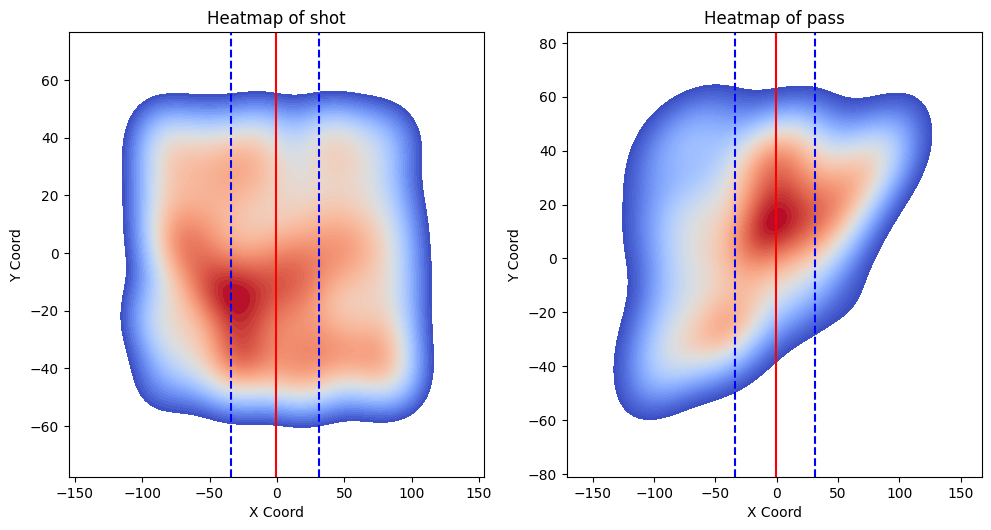

In [49]:
# Plot heatmaps for each action type showing where on the rink the AI makes different plays
plot_action_heatmaps(df_log)

In [50]:
# Compute the reward by game (or episode) and save the reward log to a CSV file.
reward_log_file = "../outputs/hockey_reward_log.csv"
df_reward = compute_reward_by_game(num_episodes=10, episode_length=100,hockey_env_rl=hockey_env_rl, reward_log_file=reward_log_file)


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Episode 0 completed. Total Reward: -9.807214555438751
Episode 1 completed. Total Reward: 1.4654943925052066e-14
Episode 2 completed. Total Reward: 1.4654943925052066e-14
Episode 3 completed. Total Reward: 1.4654943925052066e-14
Episode 4 completed. Total Reward: 1.4654943925052066e-14
Episode 5 completed. Total Reward: 1.4654943925052066e-14
Episode 6 completed. Total Reward: 1.4654943925052066e-14
Episode 7 completed. Total Reward: 1.4654943925052066e-14
Episode 8 completed. Total Reward: 1.4654943925052066e-14
Episode 9 completed. Total Reward: 1.4654943925052066e-14
Simulation complete! Logged rewards per episode.


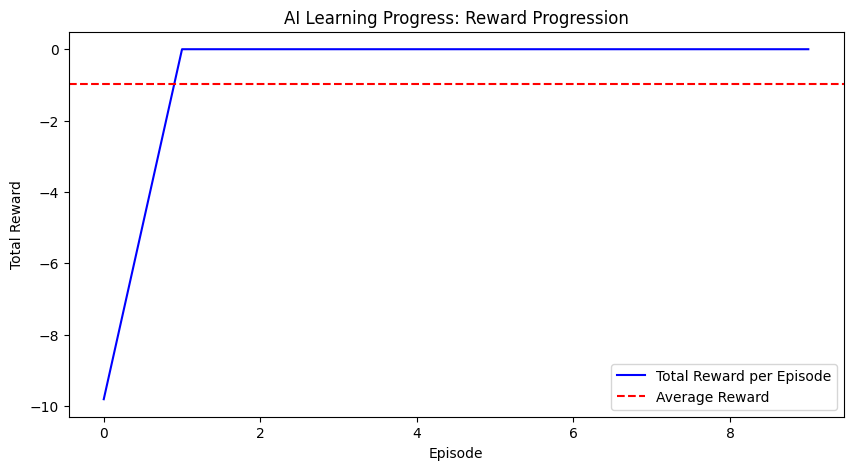

In [51]:
# Plot the reward progression over training episodes.
plot_reward_progression(df_reward)

In [52]:
# Run action test
hockey_env_rl.model = online_network
action_distribution = test_action_distribution(hockey_env_rl, num_samples=400)
print(action_distribution)


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


         Action  Count
0          shot    340
1      takeaway      0
2           hit      0
3  blocked-shot      0
4          pass     60
5      carry-in      0


In [53]:
# Pick a specific row from your DataFrame where you know the event type.
test_row = hockey_env_rl.df.iloc[15]
print("Test row eventType:", test_row["eventType"])

# Manually set current_step to that row
hockey_env_rl.current_step = 15

# Test each action
for i in range(hockey_env_rl.action_space.n):
    state, reward, done, _ = hockey_env_rl.step(i)
    print(f"Action: {hockey_env_rl.action_name(i)}, Reward: {reward}")



Test row eventType: takeaway
Action: shot, Reward: -0.021165092531147213
Action: takeaway, Reward: 2.0417777804349746
Action: hit, Reward: -0.7391826503196731
Action: blocked-shot, Reward: -0.056377145093605356
Action: pass, Reward: -0.0712469992265245
Action: carry-in, Reward: -0.08647645829020682


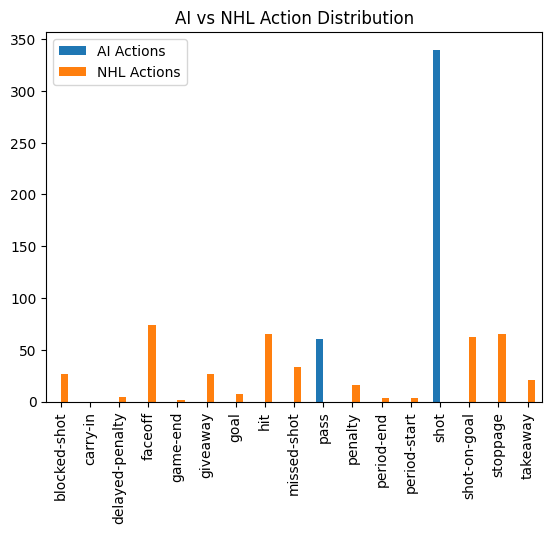

In [54]:
# Run comparison of AI's action distribution vs NHL's action distribution
compare_ai_vs_nhl(action_distribution, df)


# **Section 6: DDQN** <a id="6"></a> #
## **Section 6.1: Initialize Model** <a id="6.1"></a> ##

In [55]:
# Re-initialize hockey_env_rl for ddqn
team_to_train = "home"
team_to_train_name = get_team_name(team_to_train, df_combined)
hockey_env_rl = HockeyPlayRL(balanced_df, team_to_train_name)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Reinitialize global parameters for ddqn training
reset_globals_for_ddqn()  # Call this before training DDQN

/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## **Section 6.2: Train Model** <a id="6.2"></a> ##

In [56]:
# Set training parameters
skip_training = False
num_episodes = 100  # Increase if results are unstable
online_network_path = "../src/models/online_network_ddqn.pkl"
target_network_path = "../src/models/target_network_ddqn.pkl"

# Train the model
train_ddqn(hockey_env_rl, num_episodes, skip_training, online_network_path, target_network_path)

# Save the trained models
with open(online_network_path, "wb") as model_file:
    pickle.dump(online_network, model_file)
with open(target_network_path, "wb") as model_file:
    pickle.dump(target_network, model_file)
print("Saved new DDQN models.")

Training started...
Episode 0/100 completed. Epsilon: 1.00
Episode 10/100 completed. Epsilon: 0.99
Episode 20/100 completed. Epsilon: 0.98
Episode 30/100 completed. Epsilon: 0.97
Episode 40/100 completed. Epsilon: 0.96
Episode 50/100 completed. Epsilon: 0.95
Episode 60/100 completed. Epsilon: 0.94
Episode 70/100 completed. Epsilon: 0.93
Episode 80/100 completed. Epsilon: 0.92
Episode 90/100 completed. Epsilon: 0.91
Training complete!
Saved new DDQN models.


## **Section 6.3: Evaluate Model** <a id="6.3"></a> ##

In [57]:
# Simulate a variety of hockey game states, call predict_best_action(state), and log the AI’s decisions to a CSV file.
log_file = "../outputs/hockey_action_log_ddqn.csv"
num_simulated_states = 1000
df_log_ddqn = simulate_hockey_game(log_file, num_simulated_states, hockey_env_rl, online_network)

/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Simulation complete! Logged simulated states to hockey_action_log.csv


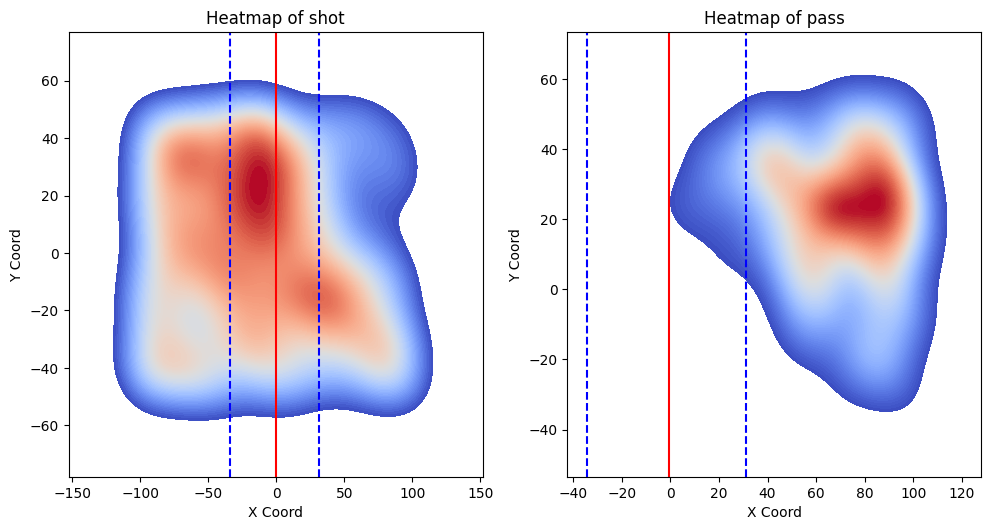

In [58]:
# Plot heatmaps for each action type showing where on the rink the AI makes different plays
plot_action_heatmaps(df_log_ddqn)

In [59]:
# Compute the reward by game (or episode) and save the reward log to a CSV file.
reward_log_file = "../outputs/hockey_reward_log_ddqn.csv"
df_reward_ddqn = compute_reward_by_game(num_episodes=10, episode_length=100, hockey_env_rl=hockey_env_rl, reward_log_file=reward_log_file)


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Episode 0 completed. Total Reward: -10.074804838908555
Episode 1 completed. Total Reward: -6.661338147750939e-15
Episode 2 completed. Total Reward: -6.661338147750939e-15
Episode 3 completed. Total Reward: -6.661338147750939e-15
Episode 4 completed. Total Reward: -6.661338147750939e-15
Episode 5 completed. Total Reward: -6.661338147750939e-15
Episode 6 completed. Total Reward: -6.661338147750939e-15
Episode 7 completed. Total Reward: -6.661338147750939e-15
Episode 8 completed. Total Reward: -6.661338147750939e-15
Episode 9 completed. Total Reward: -6.661338147750939e-15
Simulation complete! Logged rewards per episode.


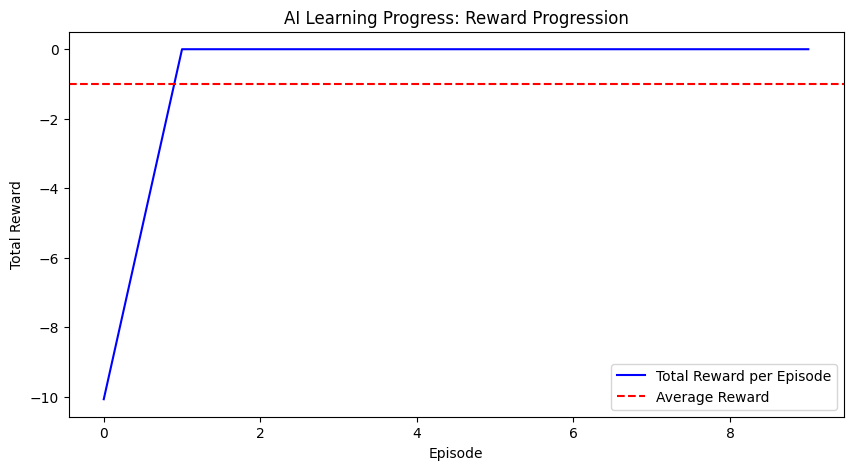

In [60]:
# Plot the reward progression over training episodes.
plot_reward_progression(df_reward_ddqn)

In [61]:
# Run action test
hockey_env_rl.model = online_network
action_distribution_ddqn = test_action_distribution(hockey_env_rl, num_samples=500)
print(action_distribution_ddqn)


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


         Action  Count
0          shot    414
1      takeaway      0
2           hit      0
3  blocked-shot      0
4          pass     86
5      carry-in      0


In [62]:
# Initialize dictionary to store rewards for each action
action_rewards = {hockey_env_rl.action_name(i): [] for i in range(hockey_env_rl.action_space.n)}
hockey_env_rl.model = online_network

for episode in range(10):  # Simulate multiple runs
    state = hockey_env_rl.reset()
    done = False
    while not done:
        action = hockey_env_rl.predict_best_action(state)
        state, reward, done, _ = hockey_env_rl.step(action)
        
        # Store reward for each action
        action_rewards[hockey_env_rl.action_name(action)].append(reward)

# Print average reward per action
for action, rewards in action_rewards.items():
    avg_reward = np.mean(rewards) if rewards else 0
    print(f"Action: {action}, Avg Reward: {avg_reward:.2f}")


Action: shot, Avg Reward: -0.20
Action: takeaway, Avg Reward: 0.00
Action: hit, Avg Reward: 0.00
Action: blocked-shot, Avg Reward: 0.00
Action: pass, Avg Reward: 0.70
Action: carry-in, Avg Reward: 0.00


In [63]:
# Test the action selection to confirm that the AI is indeed exploring different actions.
for _ in range(10):
    state = hockey_env_rl.reset()
    action = select_action(state)  # Check if exploration happens
    print(f"Chosen Action: {hockey_env_rl.action_name(action)}")


Chosen Action: takeaway
Chosen Action: takeaway
Chosen Action: hit
Chosen Action: carry-in
Chosen Action: pass
Chosen Action: carry-in
Chosen Action: hit
Chosen Action: takeaway
Chosen Action: blocked-shot
Chosen Action: blocked-shot


In [64]:
# Test the reward calculation for a specific row

test_row = hockey_env_rl.df.iloc[10]
print("Test row eventType:", test_row["eventType"])

# Manually set current_step to that row
hockey_env_rl.current_step = 10

# Test each action
for i in range(hockey_env_rl.action_space.n):
    state, reward, done, _ = hockey_env_rl.step(i)
    print(f"Action: {hockey_env_rl.action_name(i)}, Reward: {reward}")


Test row eventType: takeaway
Action: shot, Reward: -0.06441562114633388
Action: takeaway, Reward: -0.05192612786674456
Action: hit, Reward: -0.05192612786674457
Action: blocked-shot, Reward: -0.03305895838745527
Action: pass, Reward: -0.046717533450933775
Action: carry-in, Reward: -0.04012141286482959


In [65]:
# Test the Q-values for a specific state to confirm no outliers

test_state = hockey_env_rl.reset()
with torch.no_grad():
    state_tensor = torch.tensor(test_state, dtype=torch.float32).unsqueeze(0).to(device)
    q_values = online_network(state_tensor)
    print("Q-values:", q_values)


Q-values: tensor([[ 0.7961, -0.2255, -1.0233, -0.0313,  0.5569,  0.4526]],
       device='mps:0')


# **Section 7: Dueling DQN** <a id="7"></a> ##
## **Section 7.1: Initialize Model** <a id="7.1"></a> ##

In [66]:
# Initialize the dueling DQN networks
online_network, target_network = initialize_networks_duelingDQN()

# Reset global variables for Dueling DQN
reset_globals_for_duelingdqn()

# Re-initialize hockey_env_rl for dueling dqn
team_to_train = "home"
team_to_train_name = get_team_name(team_to_train, df_combined)
hockey_env_rl = HockeyPlayRL(balanced_df, team_to_train_name)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## **Section 7.2: Train Model** <a id="7.2"></a> ##

In [67]:
# Set training parameters
skip_training = False
num_episodes = 100  # Increase if results are unstable
online_network_path = "../src/models/online_network_duelingdqn.pkl"
target_network_path = "../src/models/target_network_duelingdqn.pkl"

# Train the model - uses same 
train_dqn(hockey_env_rl, num_episodes, skip_training, online_network_path, target_network_path)

# Save the trained models
with open(online_network_path, "wb") as model_file:
    pickle.dump(online_network, model_file)
with open(target_network_path, "wb") as model_file:
    pickle.dump(target_network, model_file)
print("Saved new Dueling DQN models.")

Training started...
Episode 0/100 completed. Epsilon: 1.00
Episode 10/100 completed. Epsilon: 0.99
Episode 20/100 completed. Epsilon: 0.98
Episode 30/100 completed. Epsilon: 0.97
Episode 40/100 completed. Epsilon: 0.96
Episode 50/100 completed. Epsilon: 0.95
Episode 60/100 completed. Epsilon: 0.94
Episode 70/100 completed. Epsilon: 0.93
Episode 80/100 completed. Epsilon: 0.92
Episode 90/100 completed. Epsilon: 0.91
Training complete!
Saved new Dueling DQN models.


## **Section 7.3: Evaluate Model** <a id="7.3"></a> ##

In [68]:
# Simulate a variety of hockey game states, call predict_best_action(state), and log the AI’s decisions to a CSV file.
log_file = "../outputs/hockey_action_log_duelingdqn.csv"
num_simulated_states = 1000
df_log_duelingdqn = simulate_hockey_game(log_file, num_simulated_states, hockey_env_rl, online_network)

/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Simulation complete! Logged simulated states to hockey_action_log.csv


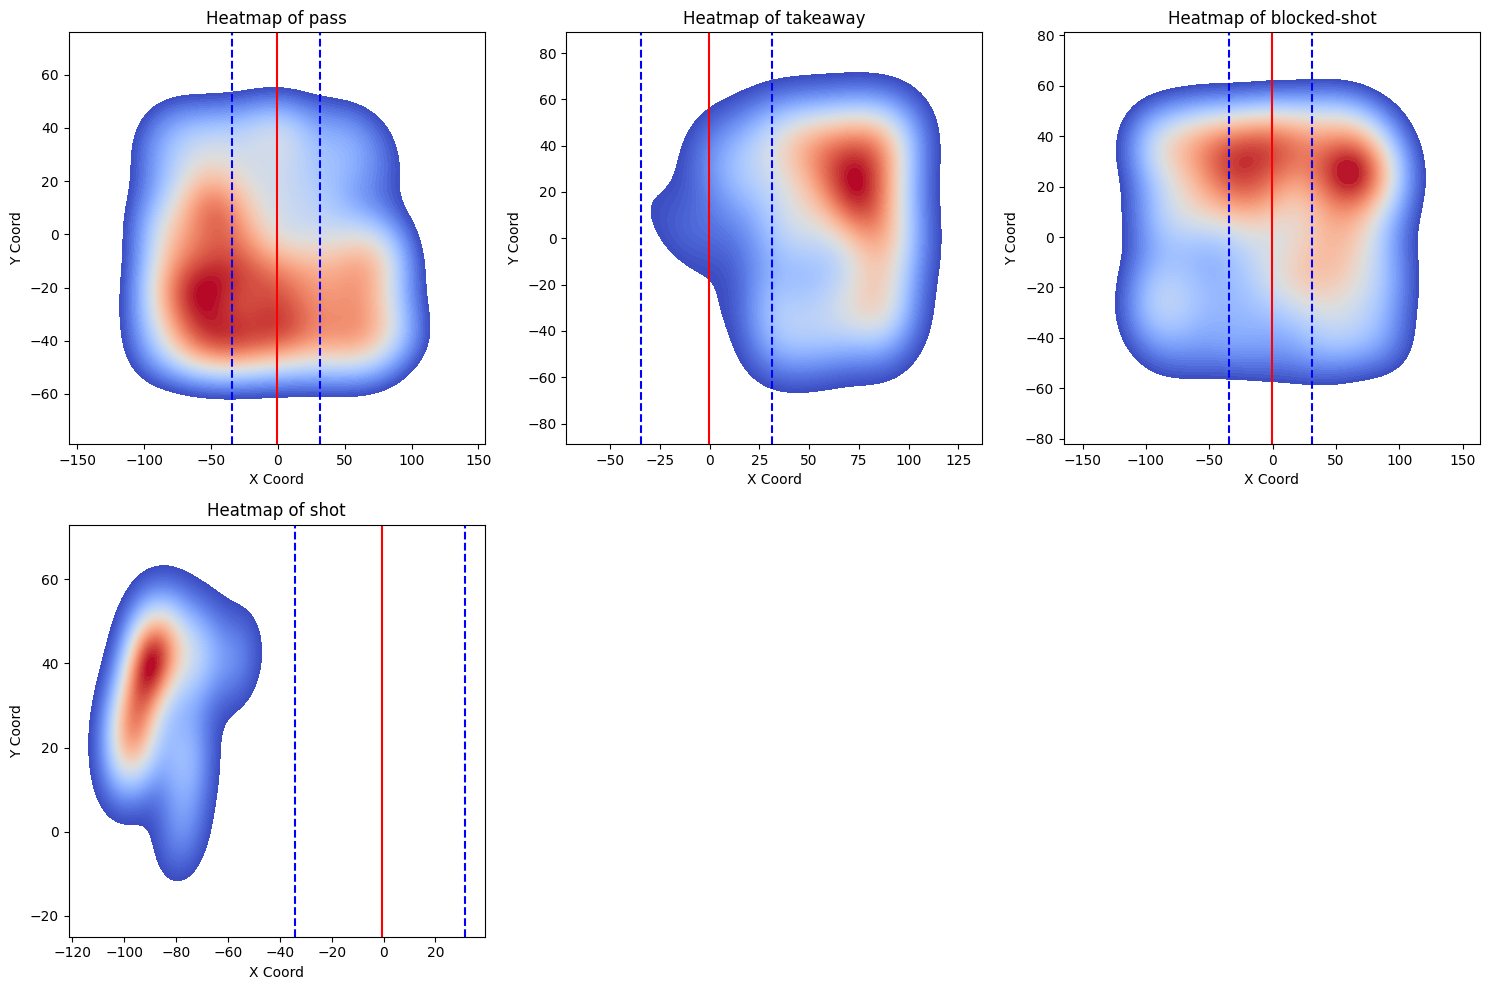

In [69]:
# Plot heatmaps for each action type showing where on the rink the AI makes different plays
plot_action_heatmaps(df_log_duelingdqn)

In [70]:
# Compute the reward by game (or episode) and save the reward log to a CSV file.
reward_log_file = "../outputs/hockey_reward_log_duelingdqn.csv"
df_reward_duelingdqn = compute_reward_by_game(num_episodes=10, episode_length=100, hockey_env_rl=hockey_env_rl, reward_log_file=reward_log_file)


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Episode 0 completed. Total Reward: -18.95986456702393
Episode 1 completed. Total Reward: 3.316791286067655e-15
Episode 2 completed. Total Reward: 3.316791286067655e-15
Episode 3 completed. Total Reward: 3.316791286067655e-15
Episode 4 completed. Total Reward: 3.316791286067655e-15
Episode 5 completed. Total Reward: 3.316791286067655e-15
Episode 6 completed. Total Reward: 3.316791286067655e-15
Episode 7 completed. Total Reward: 3.316791286067655e-15
Episode 8 completed. Total Reward: 3.316791286067655e-15
Episode 9 completed. Total Reward: 3.316791286067655e-15
Simulation complete! Logged rewards per episode.


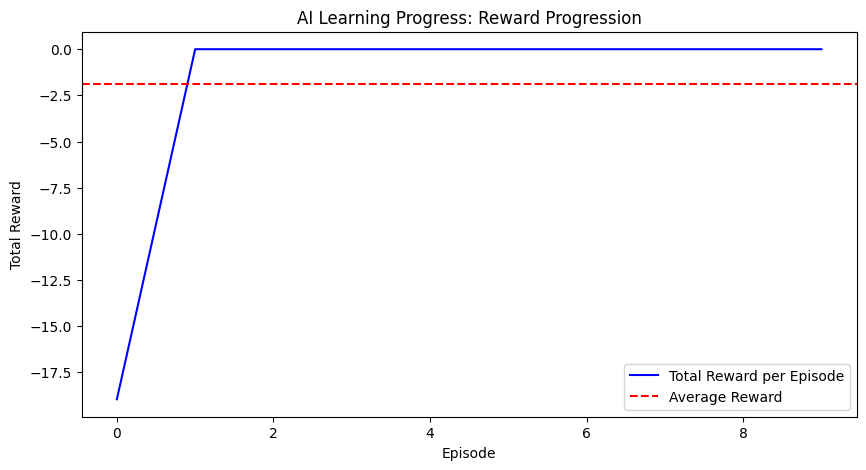

In [71]:
# Plot the reward progression over training episodes.
plot_reward_progression(df_reward_duelingdqn)

In [72]:
# Run action test
hockey_env_rl.model = online_network
action_distribution_duelingdqn = test_action_distribution(hockey_env_rl, num_samples=500)
print(action_distribution_duelingdqn)


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_21535/3666485070.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


         Action  Count
0          shot      7
1      takeaway     61
2           hit      0
3  blocked-shot    190
4          pass    242
5      carry-in      0


In [73]:
# Initialize dictionary to store rewards for each action
action_rewards = {hockey_env_rl.action_name(i): [] for i in range(hockey_env_rl.action_space.n)}
hockey_env_rl.model = online_network

for episode in range(10):  # Simulate multiple runs
    state = hockey_env_rl.reset()
    done = False
    while not done:
        action = hockey_env_rl.predict_best_action(state)
        state, reward, done, _ = hockey_env_rl.step(action)
        
        # Store reward for each action
        action_rewards[hockey_env_rl.action_name(action)].append(reward)

# Print average reward per action
for action, rewards in action_rewards.items():
    avg_reward = np.mean(rewards) if rewards else 0
    print(f"Action: {action}, Avg Reward: {avg_reward:.2f}")


Action: shot, Avg Reward: 0.92
Action: takeaway, Avg Reward: -0.20
Action: hit, Avg Reward: 0.00
Action: blocked-shot, Avg Reward: -0.29
Action: pass, Avg Reward: 0.24
Action: carry-in, Avg Reward: 0.00


In [74]:
# Test the action selection to confirm that the AI is indeed exploring different actions.
for _ in range(10):
    state = hockey_env_rl.reset()
    action = select_action(state)  # Check if exploration happens
    print(f"Chosen Action: {hockey_env_rl.action_name(action)}")


Chosen Action: takeaway
Chosen Action: carry-in
Chosen Action: pass
Chosen Action: blocked-shot
Chosen Action: shot
Chosen Action: pass
Chosen Action: blocked-shot
Chosen Action: pass
Chosen Action: shot
Chosen Action: takeaway


In [75]:
# Test the reward calculation for a specific row

test_row = hockey_env_rl.df.iloc[10]
print("Test row eventType:", test_row["eventType"])

# Manually set current_step to that row
hockey_env_rl.current_step = 10

# Test each action
for i in range(hockey_env_rl.action_space.n):
    state, reward, done, _ = hockey_env_rl.step(i)
    print(f"Action: {hockey_env_rl.action_name(i)}, Reward: {reward}")


Test row eventType: takeaway
Action: shot, Reward: 1.2205184547820342
Action: takeaway, Reward: -0.1696037758016865
Action: hit, Reward: -0.1696037758016865
Action: blocked-shot, Reward: -0.1696037758016865
Action: pass, Reward: -0.1627524829440816
Action: carry-in, Reward: -0.17914346260539188


In [76]:
# Test the Q-values for a specific state to confirm no outliers

test_state = hockey_env_rl.reset()
with torch.no_grad():
    state_tensor = torch.tensor(test_state, dtype=torch.float32).unsqueeze(0).to(device)
    q_values = online_network(state_tensor)
    print("Q-values:", q_values)


Q-values: tensor([[-17.3719, -18.1417, -18.7394, -17.0783, -16.1298, -17.5780]],
       device='mps:0')


# **Section 8: PPO** <a id="8"></a> ##
## **Section 8.1: Initialize Model** <a id="8.1"></a> ##

In [ ]:
# Initialize Environment & Model
env = hockey_env_rl  
actor_critic = ActorCritic(input_dim=5, output_dim=6)  # Adjust input_dim/output_dim for your state/action space
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

## **Section 8.2: Train Model** <a id="8.2"></a> ##

In [ ]:
# Train PPO
trained_model = train_ppo(env, actor_critic, optimizer, num_epochs=50)